# CG(TVなし)

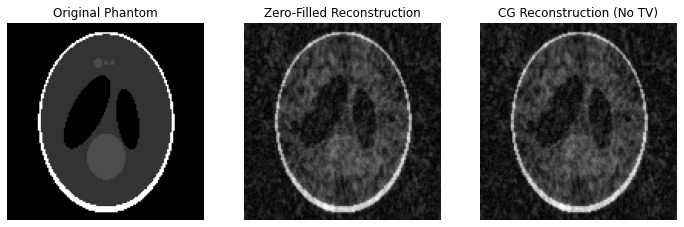

In [18]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)#.astype(np.complex128)

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# 初期化
x = np.zeros_like(img_zero_filled)#, dtype=np.complex128)  # ゼロ初期化

# A^H A の計算
AHA = A.H * A  # Hermitian なシステム

# 右辺 b の計算
b = A.H(kspace_sampled)#.astype(np.complex128)  # b = A^H y

# CG による再構成 (Preconditioner なし)
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

# 画像再構成
while not cg_solver.done():
    cg_solver.update()

# 結果を取得
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("CG Reconstruction (No TV)")
axs[2].axis("off")

plt.show()


# CG法(TV正則化あり)

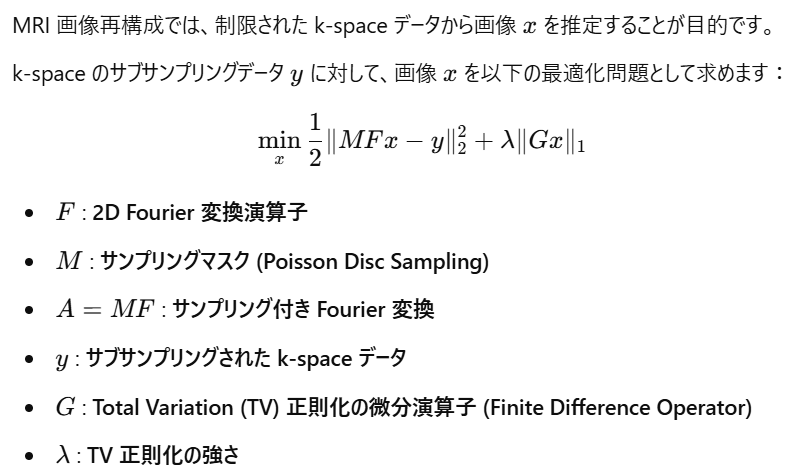

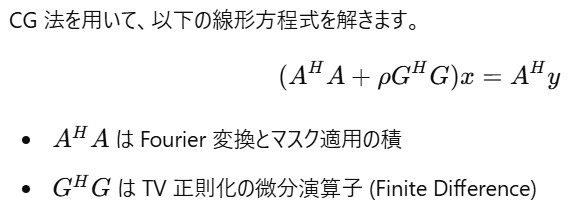

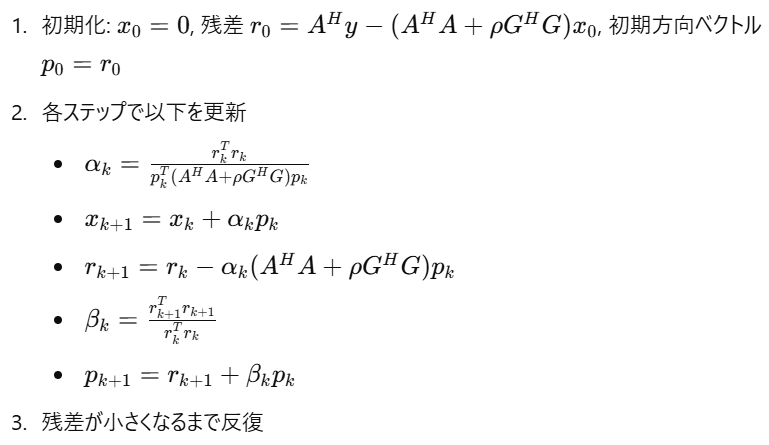

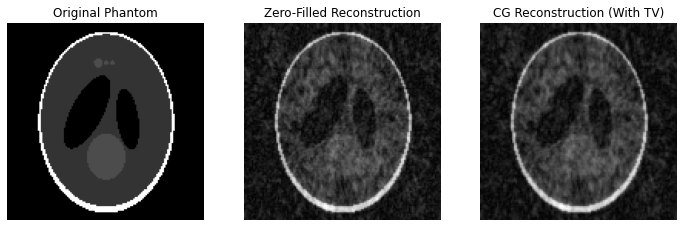

In [29]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled)#.astype(np.complex128)

# TV正則化の係数
rho = 0.1  # TV正則化の重み (調整可能)

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# TV正則化オペレータ
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # x, y の差分を取る

# 初期化
x = np.zeros_like(img_zero_filled)#, dtype=np.complex128)  # ゼロ初期化

# A^H A + ρ G^H G の計算
AHA = A.H * A + rho * G.H * G  # 正則化項を追加

# 右辺 b の計算
b = A.H(kspace_sampled)#.astype(np.complex128)  # b = A^H y

# CG による再構成 (TV 項あり)
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

# 画像再構成
while not cg_solver.done():
    cg_solver.update()

# 結果を取得
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("CG Reconstruction (With TV)")
axs[2].axis("off")

plt.show()
